<a href="https://colab.research.google.com/github/juanignaciogiacobbe/7506R-2C2023-GRUPO15/blob/main/7506R_TP2_GRUPO15_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2: Cinematográficas</center>
### <center> Grupo número 15</center>
### <center> Giacobbe, Juan Ignacio; Olaran, Sebastian; Ayala, Tomás</center>

Instalamos e importamos las librerías que vamos a utilizar

In [1]:
#Para análisis de los datos
import pandas as pd
import numpy as np

#Para visualizaciones
import seaborn as sns
from matplotlib import pyplot as plt

#Creación de redes neuronales
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.decomposition import PCA

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Declaro constantes
SEED = 15

np.random.seed(SEED)
tf.random.set_seed(SEED)

#Exploración y preprocesamiento de los datasets
Importamos los archivos

In [4]:
reviews_test = pd.read_csv('./test.csv')
reviews_train = pd.read_csv('./train.csv')

ds_cine_train = reviews_train.copy()
ds_cine_test = reviews_test.copy()

Veamos las dimensiones de cada uno

In [5]:
ds_cine_train.shape

(50000, 3)

Tenemos para el dataset de entrenamiento 50000 registros de críticas, cada una con 3 campos.

Ahora, veamos sus columnas

In [ ]:
ds_cine_train.columns.to_list()

['ID', 'review_es', 'sentimiento']

Vemos que hay una columna que tiene el ID de la review, pero no la vamos a necesitar ni para predecir ni para hacer los submits a la competencia(no nos interesa eso para entrenar los modelos), por lo que procedemos a eliminar esa columna del dataset

In [6]:
ds_cine_train.drop(['ID'], axis=1, inplace=True)

In [ ]:
ds_cine_train

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,Voy a tener que estar en desacuerdo con el com...,negativo


Veamos el dataset de test

In [ ]:
ds_cine_test.shape

(8599, 2)

Vemos que el dataset de test tiene 8599 registros para predecir. Vamos a tener que predecir con nuestros modelos predictivos la variable "sentimiento", que a partir de ahora la llamaremos "variable target".

In [ ]:
ds_cine_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


No eliminaremos la columna de ID para este dataset porque la necesitamos para subir nuestras predicciones a Kaggle.

Tratemos de encontrar datos faltantes en ambos datasets. Si esto ocurre, debemos seguir preprocesando los datasets

In [ ]:
print(ds_cine_train.isna().sum())

review_es      0
sentimiento    0
dtype: int64


Vemos que el dataset de train NO tiene datos faltantes, por lo que procedemos a hacer lo mismo pero con el dataset de test

In [ ]:
print(ds_cine_test.isna().sum())

ID           0
review_es    0
dtype: int64


Este dataset tampoco tiene datos faltantes.



---


#Separación del dataset de entrenamiento

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
features = ['review_es']

target = 'sentimiento'

Separamos el dataset de entrenamiento en un subconjunto de train y otro de test

In [9]:
#Separo un set de Evaluacion
from sklearn.model_selection import train_test_split

#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = ds_cine_train.drop([target], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = ds_cine_train[target].copy()


x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size = 0.3,    #30% al conjunto de test
                                                    random_state = SEED,  #para poder reproducir el experimento
                                                    stratify=ds_cine_train[target].values) #estratificado para mantener proporcion

#Vectorización de los datos

In [10]:
vectorizer = TfidfVectorizer()
x_train_vectorizado = vectorizer.fit_transform(x_train.review_es)
x_test_vectorizado = vectorizer.fit_transform(x_test.review_es)

In [11]:
dataset_test_vectorizado = vectorizer.fit_transform(ds_cine_test[features])

In [12]:
x_test_vectorizado

<15000x98185 sparse matrix of type '<class 'numpy.float64'>'
	with 2062617 stored elements in Compressed Sparse Row format>

# Modelo Bayes Naïve

##Primer modelo

In [ ]:
modeloBayesNaive = make_pipeline(TfidfVectorizer(), MultinomialNB())
modeloBayesNaive.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
y_pred=modeloBayesNaive.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.850003376781252

              precision    recall  f1-score   support

    negativo       0.84      0.86      0.85      7500
    positivo       0.86      0.84      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'y_pred')

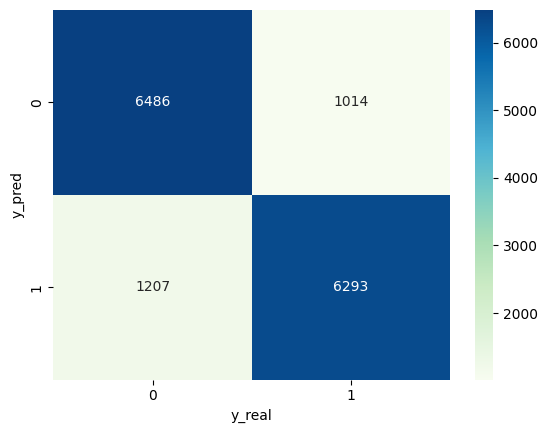

In [ ]:
y_pred = modeloBayesNaive.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modeloBayesNaive.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4435
negativo    4164
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_bayes2.csv", index = False)

##Segundo modelo

In [ ]:
# Define el modelo MultinomialNB
modelo = MultinomialNB()

# Definir los valores de hiperparámetros a buscar
param_grid = {
    'alpha': [0.1, 0.2, 0.5, 1.0, 2.0,3.0,4.0,5.0]  # Prueba diferentes valores de alpha
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=7, scoring='accuracy', verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
grid_search.fit(x_train, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = grid_search.best_estimator_

Fitting 7 folds for each of 8 candidates, totalling 56 fits
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ........................................

In [ ]:
y_pred=modelo_optimizado.predict(x_test)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')


0.8406151339240249

#####Predicción sobre el dataset test

In [ ]:
predict = modelo_optimizado.predict(x_test)

ds_resultados=pd.DataFrame(zip(ds_cine_test["ID"], predict),columns=['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

negativo    4451
positivo    4148
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,positivo
60002,positivo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,positivo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_bayes.csv", index = False)

In [ ]:
mejor_svm = best_svm

Este modelo ha obtenido una puntuación de 0.80577 en la competencia de Kaggle. Veamos si cambiando otra vez el kernel del modelo podemos seguir mejorando la performance.

##Tercer modelo

In [ ]:
frecuencia_maxima = [0.9, 0.95, 0.85, 0.98]
frecuencia_minima = [0.05, 0.07, 0.1, 0.03]
ngram_range = [(1,1), (1,2), (3,1)]
alpha = [0.1, 0.5, 1.0]
fit_prior = [True, False]
class_prior = [None, [0.2, 0.8], [0.5, 0.5]]

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

param_grid = {
  'tfidfvectorizer__max_df': frecuencia_maxima,
  'tfidfvectorizer__min_df': frecuencia_minima,
  'tfidfvectorizer__ngram_range': ngram_range,
  'multinomialnb__alpha': alpha,
  'multinomialnb__fit_prior': fit_prior,
  'multinomialnb__class_prior': class_prior
}

# Configurar GridSearchCV
grid_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=3, scoring='accuracy', verbose=2, n_iter = 20)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
grid_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = grid_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END multinomialnb__alpha=1.0, multinomialnb__class_prior=[0.5, 0.5], multinomialnb__fit_prior=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1); total time=   0.0s
[CV] END multinomialnb__alpha=1.0, multinomialnb__class_prior=[0.5, 0.5], multinomialnb__fit_prior=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1); total time=   0.0s
[CV] END multinomialnb__alpha=1.0, multinomialnb__class_prior=[0.5, 0.5], multinomialnb__fit_prior=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1); total time=   0.0s
[CV] END multinomialnb__alpha=1.0, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__max_df=0.98, tfidfvectorizer__min_df=0.03, tfidfvectorizer__ngram_range=(1, 2); total time=  28.3s
[CV] END multinomialnb__alpha=1.0, multinomialnb__class_prior=N

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pac

Mejor conjunto de hiperparámetros encontrado:
{'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__min_df': 0.03, 'tfidfvectorizer__max_df': 0.85, 'multinomialnb__fit_prior': True, 'multinomialnb__class_prior': None, 'multinomialnb__alpha': 0.1}
Mejor puntuación de validación cruzada:
0.8062571115195244


In [ ]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer(max_df=grid_search.best_params_['tfidfvectorizer__max_df'],
                                            min_df=grid_search.best_params_['tfidfvectorizer__min_df'],
                                             ngram_range=grid_search.best_params_['tfidfvectorizer__ngram_range'])),
        ('multinomialnb', MultinomialNB(alpha = grid_search.best_params_['multinomialnb__alpha'],
                                        fit_prior = grid_search.best_params_['multinomialnb__fit_prior'],
                                        class_prior= grid_search.best_params_['multinomialnb__class_prior']))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.85, min_df=0.03)),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8127345671023682

              precision    recall  f1-score   support

    negativo       0.83      0.78      0.80      7500
    positivo       0.79      0.84      0.81      7500

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



Text(50.722222222222214, 0.5, 'y_pred')

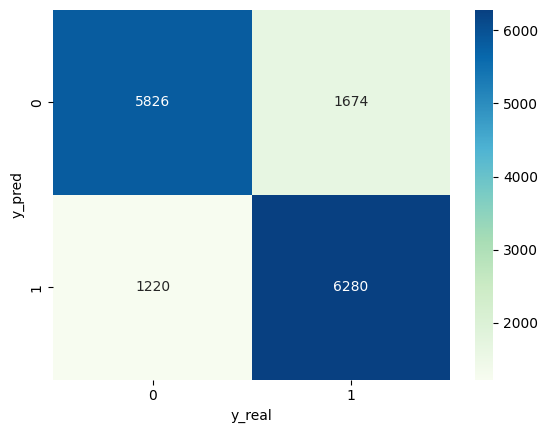

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4703
negativo    3896
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,positivo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,negativo
68595,negativo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_bayes4.csv", index = False)

##Cuarto modelo

In [ ]:
frecuencia_maxima = [0.9, 0.95, 0.85, 0.98]
frecuencia_minima = [0.05, 0.07, 0.1, 0.03]
ngram_range = [(1,1), (1,2), (3,1)]
alpha = [0.1, 0.5, 1.0]
fit_prior = [True, False]
class_prior = [None, [0.2, 0.8], [0.5, 0.5]]

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

param_grid = {
  'tfidfvectorizer__stop_words': ['english', None],
  'tfidfvectorizer__max_df': frecuencia_maxima,
  'tfidfvectorizer__min_df': frecuencia_minima,
  'tfidfvectorizer__ngram_range': ngram_range,
  'multinomialnb__alpha': alpha,
  'multinomialnb__fit_prior': fit_prior,
  'multinomialnb__class_prior': class_prior
}

# Configurar GridSearchCV
random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=10, scoring='accuracy', verbose=2, n_iter = 20)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=[0.2, 0.8], multinomialnb__fit_prior=True, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1), tfidfvectorizer__stop_words=None; total time=   0.0s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=[0.2, 0.8], multinomialnb__fit_prior=True, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1), tfidfvectorizer__stop_words=None; total time=   0.0s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=[0.2, 0.8], multinomialnb__fit_prior=True, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer__ngram_range=(3, 1), tfidfvectorizer__stop_words=None; total time=   0.0s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=[0.2, 0.8], multinomialnb__fit_prior=True, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.1, tfidfvectorizer

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Mejor conjunto de hiperparámetros encontrado:
{'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__min_df': 0.03, 'tfidfvectorizer__max_df': 0.98, 'multinomialnb__fit_prior': True, 'multinomialnb__class_prior': None, 'multinomialnb__alpha': 1.0}
Mejor puntuación de validación cruzada:
0.8072285714285714


In [ ]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer( stop_words=random_search.best_params_['tfidfvectorizer__stop_words'],
                                            max_df=random_search.best_params_['tfidfvectorizer__max_df'],
                                            min_df=random_search.best_params_['tfidfvectorizer__min_df'],
                                             ngram_range=random_search.best_params_['tfidfvectorizer__ngram_range'])),
        ('multinomialnb', MultinomialNB(alpha = random_search.best_params_['multinomialnb__alpha'],
                                        fit_prior = random_search.best_params_['multinomialnb__fit_prior'],
                                        class_prior= random_search.best_params_['multinomialnb__class_prior']))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.98, min_df=0.03, ngram_range=(1, 2),
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8147181628392485

              precision    recall  f1-score   support

    negativo       0.82      0.79      0.81      7500
    positivo       0.80      0.83      0.81      7500

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



Text(50.722222222222214, 0.5, 'y_pred')

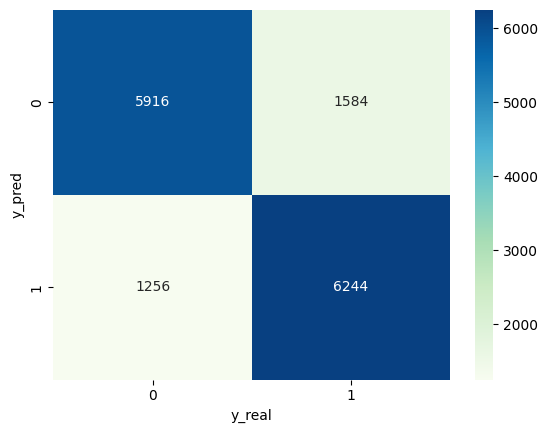

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    5025
negativo    3574
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,positivo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,negativo
68595,negativo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_bayes5.csv", index = False)

# Modelo Random forest

##Primer modelo

In [ ]:
# Crear un modelo Random Forest
modelo = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 150],  # Diferentes números de árboles en el bosque
    'max_depth': [10, 20, 30],  # Diferentes profundidades máximas de los árboles
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring='f1', verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(x_train, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = grid_search.best_estimator_



Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=10, n_estimators=50; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=10, n_estimators=50; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=10, n_estimators=50; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=10, n_estimators=50; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=10, n_estimators=50; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=100; total time=  16.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=100; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=100; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=100; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=100; total time=  16.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=150; total time=  25.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=150; total time=  24.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=150; total time=  24.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=150; total time=  24.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=10, n_estimators=150; total time=  25.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=20, n_estimators=50; total time=  19.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=20, n_estimators=50; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=20, n_estimators=50; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=20, n_estimators=50; total time=  19.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=20, n_estimators=50; total time=  18.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=100; total time=  37.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=100; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=100; total time=  38.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=100; total time=  36.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=100; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=150; total time=  55.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=150; total time=  53.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=150; total time=  56.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=150; total time=  53.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=20, n_estimators=150; total time=  53.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=30, n_estimators=50; total time=  31.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=30, n_estimators=50; total time=  31.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=30, n_estimators=50; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=30, n_estimators=50; total time=  31.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END ......................max_depth=30, n_estimators=50; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=150; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=150; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=150; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=150; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END .....................max_depth=30, n_estimators=150; total time= 1.6min
Mejor conjunto de hiperparámetros encontrado:
{'max_depth': 10, 'n_estimators': 50}
Mejor puntuación de validación cruzada:
nan


In [ ]:
y_pred=modelo_optimizado.predict(x_test)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')
f1_score(y_test, y_pred, pos_label='negativo')


0.7429543762628948

#####Predicción sobre el dataset test

In [ ]:
predict = modelo_optimizado.predict(x_test)

ds_resultados=pd.DataFrame(zip(ds_cine_test["ID"], predict),columns=['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4825
negativo    3774
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,positivo
60002,positivo
60003,positivo
60004,negativo
...,...
68594,positivo
68595,positivo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_rf1.csv", index = False)

In [ ]:
mejor_svm = best_svm

Este modelo ha obtenido una puntuación de 0.80577 en la competencia de Kaggle. Veamos si cambiando otra vez el kernel del modelo podemos seguir mejorando la performance.

## Segundo modelo


In [ ]:
# Crear un modelo Random Forest
modelo = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 201, 10),  # Diferentes números de árboles en el bosque
    'max_depth': np.arange(10, 31),  # Diferentes profundidades máximas de los árboles
    'min_samples_split': np.arange(2, 11),  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': np.arange(1, 5),  # Número mínimo de muestras requeridas para ser una hoja
    'criterion': ['gini', 'entropy'],  # Función de calidad para la división
    'class_weight': [None, 'balanced'],  # Pesos de clase para problemas de clasificación
    'oob_score': [True, False],  # Usar OOB para estimar la precisión
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_dist, n_iter=20, cv=10, scoring='f1', verbose=2)

# Realizar la búsqueda de hiperparámetros
random_search.fit(x_train_vectorizado, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  25.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  24.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  23.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  25.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  22.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  23.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=180, oob_score=False; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  22.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=False; total time=  20.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=True; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  38.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  38.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  36.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  39.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  38.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  37.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  38.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  37.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=17, min_samples_leaf=3, min_samples_split=5, n_estimators=160, oob_score=True; total time=  38.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50, oob_score=False; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  23.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  23.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  24.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  24.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  25.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=6, n_estimators=60, oob_score=True; total time=  25.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  18.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  17.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=27, min_samples_leaf=4, min_samples_split=8, n_estimators=50, oob_score=False; total time=  18.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  52.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  55.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  54.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  53.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  52.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  54.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  54.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  53.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  52.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=21, min_samples_leaf=4, min_samples_split=3, n_estimators=190, oob_score=True; total time=  54.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  19.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  19.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  20.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=160, oob_score=False; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  36.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  37.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  36.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  38.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=200, oob_score=True; total time=  37.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=28, min_samples_leaf=2, min_samples_split=10, n_estimators=190, oob_score=True; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  32.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  33.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  32.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  31.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, min_samples_leaf=4, min_samples_split=3, n_estimators=90, oob_score=True; total time=  30.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=11, min_samples_leaf=3, min_samples_split=3, n_estimators=80, oob_score=False; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  38.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  39.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  38.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  38.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  39.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  38.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  37.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=29, min_samples_leaf=4, min_samples_split=3, n_estimators=100, oob_score=True; total time=  38.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  18.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100, oob_score=False; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  36.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  34.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  36.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  34.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  35.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  34.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  35.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  35.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  34.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=balanced, criterion=gini, max_depth=23, min_samples_leaf=2, min_samples_split=7, n_estimators=110, oob_score=False; total time=  35.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=16, min_samples_leaf=3, min_samples_split=7, n_estimators=60, oob_score=True; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  40.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  40.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  38.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  37.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  36.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  38.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  39.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  43.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=gini, max_depth=24, min_samples_leaf=2, min_samples_split=4, n_estimators=110, oob_score=True; total time=  42.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  42.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  43.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  37.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  41.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  42.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  40.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  39.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

[CV] END class_weight=None, criterion=entropy, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150, oob_score=False; total time=  40.4s


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200]),
                                        'oob_score': [True, False]},
                   scoring='f1', verbose=2)

In [ ]:
# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Mejor conjunto de hiperparámetros encontrado:
{'oob_score': False, 'n_estimators': 180, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}
Mejor puntuación de validación cruzada:
nan


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x_train_vectorizado = vectorizer.fit_transform(x_train.review_es)
x_test_vectorizado = vectorizer.transform(x_test.review_es)


# Define los hiperparámetros
rf_params = {
    'n_estimators': 180,
    'min_samples_split': 8,
    'min_samples_leaf': 8,
    'max_depth': 10,
    'criterion': 'entropy',
    'class_weight': None
}

# Crea el RandomForestClassifier con los hiperparámetros
modelo_optimizado = RandomForestClassifier(**rf_params)

# A continuación, puedes ajustar este modelo a tus datos de entrenamiento
modelo_optimizado.fit(x_train_vectorizado, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=8,
                       min_samples_split=8, n_estimators=180)

In [ ]:
y_pred=modelo_optimizado.predict(x_test_vectorizado)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')



0.8154168518636103

#####Predicción sobre el dataset test

In [ ]:
predict = modelo_optimizado.predict(x_test_vectorizado)

ds_resultados=pd.DataFrame(zip(ds_cine_test["ID"], predict),columns=['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4769
negativo    3830
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,negativo
68595,negativo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_rf3.csv", index = False)

Este modelo ha obtenido una puntuación de 0.80577 en la competencia de Kaggle. Veamos si cambiando otra vez el kernel del modelo podemos seguir mejorando la performance.

##Tercer modelo

In [15]:
modelo = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [16]:
y_pred=modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.829523362606422

              precision    recall  f1-score   support

    negativo       0.83      0.84      0.83      7500
    positivo       0.83      0.82      0.83      7500

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

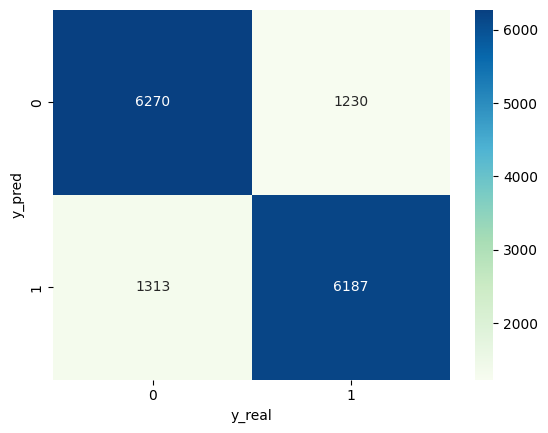

In [17]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [18]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4869
negativo    3730
Name: sentimiento, dtype: int64

In [19]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [20]:
ds_resultados.to_csv("predicciones_rf1.csv", index = False)

## Cuarto modelo

In [27]:
frecuencia_maxima = [0.9, 0.95, 0.85, 0.98]
frecuencia_minima = [0.05, 0.07, 0.1, 0.03]
ngram_range = [(1,1), (1,2), (3,1)]
n_estimators = np.arange(50, 201, 10)
max_depth = np.arange(10, 31)
min_samples_leaf = np.arange(1, 5)
min_samples_split = np.arange(2, 11)
criterion = ['gini', 'entropy']
oob_score = [True, False]

gsrf = RandomForestClassifier(class_weight="balanced")

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('gsrf', gsrf)])

param_grid = {
  'tfidfvectorizer__max_df': frecuencia_maxima,
  'tfidfvectorizer__min_df': frecuencia_minima,
  'tfidfvectorizer__ngram_range': ngram_range,
  'gsrf__n_estimators': n_estimators,
  'gsrf__max_depth': max_depth,
  'gsrf__min_samples_leaf': min_samples_leaf,
  'gsrf__min_samples_split': min_samples_split,
  'gsrf__criterion': criterion,
  'gsrf__oob_score': oob_score
}

# Configurar GridSearchCV
random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=3, n_iter = 1, scoring='accuracy', verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gsrf__criterion=entropy, gsrf__max_depth=28, gsrf__min_samples_leaf=4, gsrf__min_samples_split=5, gsrf__n_estimators=80, gsrf__oob_score=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.07, tfidfvectorizer__ngram_range=(1, 2); total time= 1.2min
[CV] END gsrf__criterion=entropy, gsrf__max_depth=28, gsrf__min_samples_leaf=4, gsrf__min_samples_split=5, gsrf__n_estimators=80, gsrf__oob_score=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.07, tfidfvectorizer__ngram_range=(1, 2); total time= 1.1min
[CV] END gsrf__criterion=entropy, gsrf__max_depth=28, gsrf__min_samples_leaf=4, gsrf__min_samples_split=5, gsrf__n_estimators=80, gsrf__oob_score=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__min_df=0.07, tfidfvectorizer__ngram_range=(1, 2); total time= 1.1min
Mejor conjunto de hiperparámetros encontrado:
{'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__min_df': 0.07, 'tfidfvectorizer_

In [30]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer(max_df=random_search.best_params_['tfidfvectorizer__max_df'],
                                            min_df=random_search.best_params_['tfidfvectorizer__min_df'],
                                             ngram_range=random_search.best_params_['tfidfvectorizer__ngram_range'])),
        ('gsrf', RandomForestClassifier(class_weight="balanced",
                                        oob_score = random_search.best_params_['gsrf__oob_score'],
                                        n_estimators= random_search.best_params_['gsrf__n_estimators'],
                                        min_samples_split= random_search.best_params_['gsrf__min_samples_split'],
                                        min_samples_leaf= random_search.best_params_['gsrf__min_samples_leaf'],
                                        max_depth= random_search.best_params_['gsrf__max_depth'],
                                        criterion= random_search.best_params_['gsrf__criterion'],))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.07, ngram_range=(1, 2))),
                ('gsrf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=28,
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=80))])

In [31]:
y_pred=modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.7734679532238481

              precision    recall  f1-score   support

    negativo       0.79      0.72      0.75      7500
    positivo       0.74      0.81      0.77      7500

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.76     15000



Text(50.722222222222214, 0.5, 'y_pred')

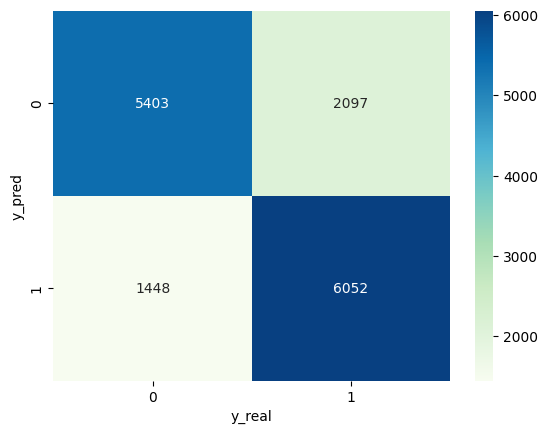

In [32]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [33]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4632
negativo    3967
Name: sentimiento, dtype: int64

In [34]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,positivo
...,...
68594,positivo
68595,positivo
68596,negativo


In [35]:
ds_resultados.to_csv("predicciones_rf5.csv", index = False)